# Babyweight Estimation with Transformed Data

## 1. Preparation

### Install required packages

In [ ]:
pip install --ignore-installed tensorflow-transform==1.6.0

You can ingnore the dependency resolver errors. Confirm the final message starting with "Successfully installed ..."

**Now you have to restart kernel from the menu bar: "Kernel" -> "Restart Kernel".**

After restarting the kernel, you can resume the code execution from the next cell.

### Confirm the installed packages

In [1]:
!pip list | grep -E '(tensorflow|beam)'

apache-beam                           2.35.0
tensorflow                            2.7.0
tensorflow-cloud                      0.1.16
tensorflow-datasets                   4.4.0
tensorflow-estimator                  2.7.0
tensorflow-hub                        0.12.0
tensorflow-io                         0.21.0
tensorflow-io-gcs-filesystem          0.23.1
tensorflow-metadata                   1.6.0
tensorflow-probability                0.14.1
tensorflow-serving-api                2.7.0
tensorflow-transform                  1.6.0


### Set global flags

In [2]:
PROJECT = 'your-project'
BUCKET = 'your-project-babyweight'
REGION = 'us-central1'
ROOT_DIR = 'babyweight_tft'

In [3]:
import os

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['ROOT_DIR'] = ROOT_DIR

In [4]:
OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET,ROOT_DIR)
TRANSFORM_ARTEFACTS_DIR = os.path.join(OUTPUT_DIR,'transform')
TRANSFORMED_DATA_DIR = os.path.join(OUTPUT_DIR,'transformed')
TEMP_DIR = os.path.join(OUTPUT_DIR, 'tmp')
MODELS_DIR = os.path.join(OUTPUT_DIR,'models')

### Import required packages and modules

In [5]:
import math, os

import tensorflow as tf
import tensorflow_transform as tft

from tensorflow.keras import layers, models

## 2. Define deep and wide regression model

### Check features in the transformed data

You can use these features (except the target feature) as an input to the model.

In [6]:
transformed_metadata = tft.TFTransformOutput(TRANSFORM_ARTEFACTS_DIR).transformed_metadata
transformed_metadata.schema

feature {
  name: "gestation_weeks_scaled"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "is_male_index"
  type: INT
  int_domain {
    min: -1
    max: 1
    is_categorical: true
  }
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "is_multiple_index"
  type: INT
  int_domain {
    min: -1
    max: 1
    is_categorical: true
  }
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "mother_age_bucketized"
  type: INT
  int_domain {
    min: 0
    max: 4
    is_categorical: true
  }
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "mother_age_log"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "mother_age_normalized"
  type: FLOAT
  presence {
    min_fraction: 1.0
  }
  shape {
  }
}
feature {
  name: "mother_race_index"
  type: INT
  int_domain {
    min: -1
    max: 10
    is_categorical: true
  }
  presence {
    min_fraction: 1.0
  }
 

### Define wide and deep feature columns

This is a feature engineering layer that creates new features from the transformed data.

In [7]:
def create_wide_and_deep_feature_columns():

    deep_feature_columns = []
    wide_feature_columns = []
    inputs = {}
    categorical_columns = {}

    # Select features you've checked from the metadata
    # - Categorical features are associated with the vocabulary size (starting from 0)
    numeric_features = ['mother_age_log', 'mother_age_normalized', 'gestation_weeks_scaled']
    categorical_features = [('is_male_index', 1), ('is_multiple_index', 1),
                            ('mother_age_bucketized', 4), ('mother_race_index', 10)]

    for feature in numeric_features:
        deep_feature_columns.append(tf.feature_column.numeric_column(feature))
        inputs[feature] = layers.Input(shape=(), name=feature, dtype='float32')

    for feature, vocab_size in categorical_features:
        categorical_columns[feature] = (
            tf.feature_column.categorical_column_with_identity(feature, num_buckets=vocab_size+1))
        wide_feature_columns.append(tf.feature_column.indicator_column(categorical_columns[feature]))
        inputs[feature] = layers.Input(shape=(), name=feature, dtype='int64')

    mother_race_X_mother_age_bucketized = tf.feature_column.crossed_column(
        [categorical_columns['mother_age_bucketized'],
         categorical_columns['mother_race_index']],  55)
    wide_feature_columns.append(tf.feature_column.indicator_column(mother_race_X_mother_age_bucketized))
        
    mother_race_X_mother_age_bucketized_embedded = tf.feature_column.embedding_column(
        mother_race_X_mother_age_bucketized, 5)        
    deep_feature_columns.append(mother_race_X_mother_age_bucketized_embedded)

    return wide_feature_columns, deep_feature_columns, inputs

### Define a regression model

In [8]:
def create_model():

    wide_feature_columns, deep_feature_columns, inputs = create_wide_and_deep_feature_columns()
    feature_layer_wide = layers.DenseFeatures(wide_feature_columns, name='wide_features')
    feature_layer_deep = layers.DenseFeatures(deep_feature_columns, name='deep_features')

    wide_model = feature_layer_wide(inputs)
    
    deep_model = layers.Dense(64, activation='relu', name='DNN_layer1')(feature_layer_deep(inputs))
    deep_model = layers.Dense(32, activation='relu', name='DNN_layer2')(deep_model)

    wide_deep_model = layers.Dense(1, name='weight')(layers.concatenate([wide_model, deep_model]))
    model = models.Model(inputs=inputs, outputs=wide_deep_model)

    # Compile Keras model
    model.compile(loss='mse', optimizer='adam') # tf.keras.optimizers.Adam(learning_rate=0.0001))

    return model

### Define tfrecords_input_fn

This function creates a batched dataset from the transformed dataset.

In [9]:
def tfrecords_input_fn(files_name_pattern, batch_size=512):
    
    tf_transform_output = tft.TFTransformOutput(TRANSFORM_ARTEFACTS_DIR)
    TARGET_FEATURE_NAME = 'weight_pounds'

    batched_dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=files_name_pattern,
        batch_size=batch_size,
        features=tf_transform_output.transformed_feature_spec(),
        reader=tf.data.TFRecordDataset,
        label_key=TARGET_FEATURE_NAME,
        shuffle=True).prefetch(tf.data.experimental.AUTOTUNE)

    return batched_dataset

## 3. Train and export the model

In [10]:
def train_and_evaluate(train_pattern, eval_pattern):

    train_dataset = tfrecords_input_fn(train_pattern, batch_size=BATCH_SIZE)
    validation_dataset = tfrecords_input_fn(eval_pattern, batch_size=BATCH_SIZE)

    model = create_model()
    print(model.summary())

    print('Now training the model... hang on')
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=NUM_EPOCHS,
        steps_per_epoch=math.ceil(NUM_TRAIN_INSTANCES / BATCH_SIZE),
        validation_steps=math.ceil(NUM_TEST_INSTANCES / BATCH_SIZE),
        verbose=0)

    print('Evaluate the trained model.')
    print(model.evaluate(validation_dataset, steps=NUM_TEST_INSTANCES))
    
    return history, model

In [11]:
train_pattern = os.path.join(TRANSFORMED_DATA_DIR, 'train-*.tfrecords')
eval_pattern = os.path.join(TRANSFORMED_DATA_DIR, 'eval-*.tfrecords')

DATA_SIZE = 10000
BATCH_SIZE = 512
NUM_EPOCHS = 100
NUM_TRAIN_INSTANCES = math.ceil(DATA_SIZE * 0.7)
NUM_TEST_INSTANCES = math.ceil(DATA_SIZE * 0.3)

history, trained_model = train_and_evaluate(train_pattern, eval_pattern)

2022-02-01 23:14:24.140178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-02-01 23:14:24.140253: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-01 23:14:24.140281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-7-20220129-113628): /proc/driver/nvidia/version does not exist
2022-02-01 23:14:24.140567: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gestation_weeks_scaled (InputL  [(None,)]           0           []                               
 ayer)                                                                                            
                                                                                                  
 is_male_index (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 is_multiple_index (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 mother_age_bucketized (InputLa  [(None,)]           0           []                           

### Visualize the training result

Final RMSE for the validation set: 1.097103


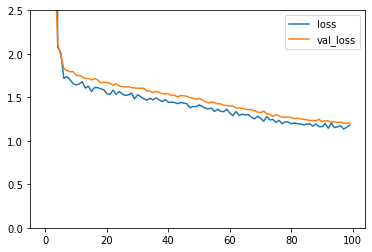

In [12]:
from pandas import DataFrame
DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']}).plot(ylim=(0, 2.5))
print('Final RMSE for the validation set: {:f}'.format(math.sqrt(history.history['val_loss'][-1])))

### Export the trained model

The serving function `serveing_fn` receives raw input data and apply the tranformation before making predictions with the trained model.

You can also add some pre/post-processing within the seriving function. In this example, it accepts an unique identifier for each instance and passes through it to the output, that is useful for batch predictions.

In [13]:
def export_serving_model(model, output_dir):

    tf_transform_output = tft.TFTransformOutput(TRANSFORM_ARTEFACTS_DIR)
    # The layer has to be saved to the model for keras tracking purposes.
    model.tft_layer = tf_transform_output.transform_features_layer()

    @tf.function
    def serveing_fn(uid, is_male, mother_race, mother_age, plurality, gestation_weeks):
        features = {
            'is_male': is_male, 
            'mother_race': mother_race, 
            'mother_age': mother_age, 
            'plurality': plurality, 
            'gestation_weeks': gestation_weeks
        } 
        transformed_features = model.tft_layer(features)
        outputs = model(transformed_features)
        # The prediction results have multiple elements in general.
        # But we need only the first element in our case.
        outputs = tf.map_fn(lambda item: item[0], outputs)

        return {'uid': uid, 'weight': outputs}

    concrete_serving_fn = serveing_fn.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string, name='uid'),
        tf.TensorSpec(shape=[None], dtype=tf.string, name='is_male'),
        tf.TensorSpec(shape=[None], dtype=tf.string, name='mother_race'),
        tf.TensorSpec(shape=[None], dtype=tf.float32, name='mother_age'),
        tf.TensorSpec(shape=[None], dtype=tf.float32, name='plurality'),
        tf.TensorSpec(shape=[None], dtype=tf.float32, name='gestation_weeks')
    )
    signatures = {'serving_default': concrete_serving_fn}

    model.save(output_dir, save_format='tf', signatures=signatures)

In [14]:
EXPORT_DIR = os.path.join(MODELS_DIR, 'export')
export_serving_model(trained_model, EXPORT_DIR)
os.environ['EXPORT_DIR'] = EXPORT_DIR

INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:struct2tensor is not available.


2022-02-01 23:17:14.544255: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://your-project-babyweight/babyweight_tft/models/export/assets


### Explore the exported model

In [15]:
%%bash
gsutil ls -lR $EXPORT_DIR
saved_model_cli show --all --dir=$EXPORT_DIR

gs://your-project-babyweight/babyweight_tft/models/export/:
         0  2022-01-30T13:06:03Z  gs://your-project-babyweight/babyweight_tft/models/export/
     26766  2022-02-01T23:17:20Z  gs://your-project-babyweight/babyweight_tft/models/export/keras_metadata.pb
    723743  2022-02-01T23:17:20Z  gs://your-project-babyweight/babyweight_tft/models/export/saved_model.pb

gs://your-project-babyweight/babyweight_tft/models/export/assets/:
         0  2022-01-30T13:06:07Z  gs://your-project-babyweight/babyweight_tft/models/export/assets/
        11  2022-01-30T13:06:08Z  gs://your-project-babyweight/babyweight_tft/models/export/assets/is_male
        11  2022-01-30T13:06:09Z  gs://your-project-babyweight/babyweight_tft/models/export/assets/is_multiple
       102  2022-01-30T13:06:07Z  gs://your-project-babyweight/babyweight_tft/models/export/assets/mother_race

gs://your-project-babyweight/babyweight_tft/models/export/variables/:
         0  2022-01-30T13:06:03Z  gs://your-project-babyweight

2022-02-01 23:17:26.989130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-02-01 23:17:26.989176: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-01 23:17:26.989199: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-7-20220129-113628): /proc/driver/nvidia/version does not exist


## 4. Use the exported model

### Load the exported model

In [16]:
#tf.keras.backend.clear_session()
model = tf.keras.models.load_model(EXPORT_DIR)


Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f91b2e5bb50> and <keras.engine.input_layer.InputLayer object at 0x7f91b92c77d0>).


### Define a local prediction function

The serving function of the exported model accepts input data with named options. You can use this wrapper to use input data in the standard python dictionary.

When you deply the model to Vertex AI using the pre-built container, you can use the Python client library to make online predictions without the wrapper.

In [17]:
def predict(requests):

    uid, is_male, mother_race, mother_age, plurality, gestation_weeks = [], [], [], [], [], []
    for instance in requests:
        uid.append(instance['uid'])
        is_male.append(instance['is_male'])
        mother_race.append(instance['mother_race'])
        mother_age.append(instance['mother_age'])
        plurality.append(instance['plurality'])
        gestation_weeks.append(float(instance['gestation_weeks']))

    result = model.signatures['serving_default'](
        uid = tf.convert_to_tensor(uid),
        is_male = tf.convert_to_tensor(is_male),
        mother_race = tf.convert_to_tensor(mother_race),
        mother_age = tf.convert_to_tensor(mother_age),
        plurality = tf.convert_to_tensor(plurality),
        gestation_weeks = tf.convert_to_tensor(gestation_weeks))

    result = zip(result['uid'].numpy().tolist(), result['weight'].numpy().tolist())
    result = [{'uid': output[0].decode('ascii'), 'weight': output[1]} for output in result]
    return {'predictions': result}

### Make local predictions

In [18]:
instance1 = {
    'uid': 'instance1',
    'is_male': 'True',
    'mother_age': 26.0,
    'mother_race': 'Asian Indian',
    'plurality': 1.0,
    'gestation_weeks': 39
}

instance2 = {
    'uid': 'instance2',
    'is_male': 'False',
    'mother_age': 40.0,
    'mother_race': 'Japanese',
    'plurality': 2.0,
    'gestation_weeks': 37
}

predict([instance1, instance2])

{'predictions': [{'uid': 'instance1', 'weight': 7.38566780090332},
  {'uid': 'instance2', 'weight': 5.597816467285156}]}

### Deploy model to Vertex AI

Deployment of the model may take minutes. Please hang on.

In [19]:
%%bash
ts=$(date +%y%m%d-%H%M%S)
MODEL_NAME="babyweight-$ts"
ENDPOINT_NAME="babyweight-endpoint-$ts"

gcloud ai models upload --region=$REGION --display-name=$MODEL_NAME \
  --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-7:latest \
  --artifact-uri=$EXPORT_DIR
MODEL_ID=$(gcloud ai models list --region=$REGION \
  --filter=display_name=$MODEL_NAME --format "value(MODEL_ID)")

gcloud ai endpoints create --region=$REGION --display-name=$ENDPOINT_NAME
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
  --filter=display_name=$ENDPOINT_NAME --format "value(ENDPOINT_ID)")

gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION --model=$MODEL_ID --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 --max-replica-count=3 --traffic-split=0=100

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [4193713888673398784]...
.........................................done.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [5954621342975262720]...
.........done.
Created Vertex AI endpoint: projects/53766238413/locations/us-central1/endpoints/5771864299777556480.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [7215629238639001600]...
.......................................................................................................................................................................................................................................................................................................................................................................................

### Make online preditions with Python client library

In [21]:
from google.cloud import aiplatform

# Use the latest endpoint that starts with 'babyweight-endpoint'
endpoints = aiplatform.Endpoint.list(
    project=PROJECT, location=REGION, order_by='create_time desc')
for item in endpoints:
    if item.display_name.startswith('babyweight-endpoint'):
        endpoint = item
        break

endpoint.predict(instances=[instance1, instance2]).predictions

[{'uid': 'instance1', 'weight': 7.3856678},
 {'uid': 'instance2', 'weight': 5.59781647}]